In [1]:
# External Libraries
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import skimage.io

# Builtin libraries
import os
import math
import pathlib
import collections
import itertools
import functools
from pprint import pprint

## nonogramize the image using PIL

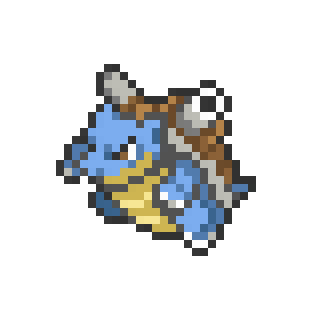

In [2]:
im = Image.open("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")

im = im.convert("RGBA", palette=Image.ADAPTIVE, colors=256)
# im = im.convert('P', palette=Image.WEB, colors=12)
# im = im.convert('P', dither=Image.NONE, palette=Image.ADAPTIVE, colors=5)
# im = im.convert("RGBA", palette=Image.ADAPTIVE, colors=256)
pix = im.load()
W, H = im.size

# Resize to view
ratio = math.ceil(300/W)
im.resize([W * ratio, H * ratio], resample=Image.NEAREST)

#### Find start and end row/col

In [3]:
# First and Last Row/Column
f_row = l_row = f_col = l_col = None
for y in range(H):
    for x in range(W):
        if pix[x, y] == (255, 255, 255, 0): continue
        if not f_row: f_row = y
        l_row = y
        if not f_col or x < f_col: f_col = x
        if not l_col or x > l_col: l_col = x
print(f_row, l_row, f_col, l_col)

8 31 7 31


In [4]:
# Count color freq
rows_count = {}
for y in range(f_row, l_row + 1):
    count = []
    row = []
    for x in range(f_col, l_col + 1):
        p = pix[x, y]
        row.append("#%02x%02x%02x%02x"%(p[0], p[1], p[2], p[3]))
    for k, grp in itertools.groupby(row):
        count.append((k, len(list(grp))))
    rows_count[y] = count
    
for k, count in rows_count.items():
    rows_count[k] = list(filter(lambda x: x[0] != "#ffffff00", count))
pprint(rows_count, compact=True)

{8: [('#363636ff', 1), ('#313131ff', 1)],
 9: [('#363636ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#333333ff', 1)],
 10: [('#363636ff', 1), ('#babab2ff', 1), ('#bdbdb5ff', 2), ('#333333ff', 1),
      ('#363636ff', 1), ('#313131ff', 1)],
 11: [('#353535ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#bdbdb5ff', 2),
      ('#333333ff', 1), ('#353535ff', 1), ('#313131ff', 3), ('#fbfbfbff', 1),
      ('#ffffffff', 1), ('#343434ff', 1)],
 12: [('#363636ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#8c643aff', 1),
      ('#6b4a29ff', 1), ('#313130ff', 1), ('#313131ff', 2), ('#b28249ff', 1),
      ('#6c4a29ff', 1), ('#525151ff', 1), ('#fcfcfcff', 1), ('#343434ff', 1),
      ('#313131ff', 1), ('#fbfbfbff', 1), ('#343434ff', 1)],
 13: [('#353535ff', 1), ('#79abecff', 1), ('#323233ff', 1), ('#8a6238ff', 1),
      ('#6b4a29ff', 1), ('#b38349ff', 1), ('#b5844aff', 1), ('#6c4a29ff', 1),
      ('#b38349ff', 1), ('#6c4a29ff', 1), ('#525151ff', 1), ('#bbbbb3ff', 1),
      ('#fdfdfdff', 1), ('#3434

## nonogramize the image using skimage and np

In [5]:
def reduce_color_palette(im, n_colors=7):
    """
    Reduce color palette using K-means
    n_colors: number of colors in the final image
    """
    im = np.copy(im)
    # Transform image to array
    w,h,z = im.shape
    im = im.reshape(w*h,z)
    
    # Train model
    kmeans = KMeans(n_clusters=n_colors, 
                    n_init=32, 
                    max_iter=500, 
                    tol=0.0001,
                    random_state=0,
                   ).fit(im)
    
    # find out which cluster each pixel belongs to.
    labels = kmeans.predict(im)
    
    # the cluster centroids is our color palette
    identified_palette = np.array(kmeans.cluster_centers_).astype(int)
    
    # recolor the entire image
    recolored_img = np.copy(im)
    for index in range(len(im)):
        im[index] = identified_palette[labels[index]]
    
    # reshape for display
    im = im.reshape(w,h,z)
    
    return im

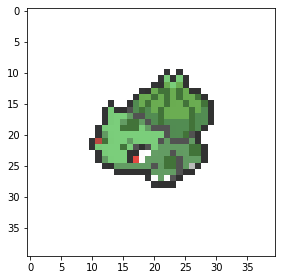

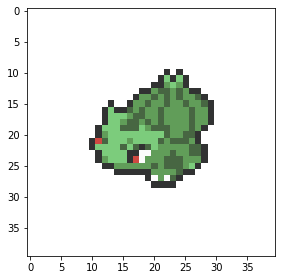

In [9]:
im = skimage.io.imread("../DataScraping/data/pokemon_sprites_bulbapedia/001_Bulbasaur.png")
skimage.io.imshow(im)
skimage.io.show()
im = reduce_color_palette(im, 7) # im[:,:,:-1] to Exclude alpha
skimage.io.imshow(im)
skimage.io.show()

In [7]:
# Find First and Last Row/Column
f_row = l_row = f_col = l_col = None
for r, row in enumerate(im):
    for c, p in enumerate(row):
        pixel = "#%02x%02x%02x%02x"%(p[0], p[1], p[2], p[3])
        if pixel[1:-2:2] == "fff": continue
        if pixel[1:-2:2] == "000": continue
        if not f_row: f_row = r
        l_row = r
        if not f_col or c < f_col: f_col = c
        if not l_col or c > l_col: l_col = c
print(f_row, l_row, f_col, l_col)

# Dictionry of rows
rows_count = {}
for r in range(f_row, l_row + 1):
    count = []
    row =["#%02x%02x%02x%02x"%(p[0], p[1], p[2], p[3]) for p in im[r,:]]
    for k, grp in itertools.groupby(row):
        count.append((k, len(list(grp))))
    rows_count[r] = count
    
for k, count in rows_count.items():
    rows_count[k] = list(filter(lambda x:x[0][1:-2:2] not in ("fff", "000"), 
                                count))
pprint(rows_count, width=120, compact=True)

# Dictionry of cols
cols_count = {}
for c in range(f_col, l_col + 1):
    count = []
    col =["#%02x%02x%02x%02x"%(p[0], p[1], p[2], p[3]) for p in im[:,c]]
    for k, grp in itertools.groupby(col):
        count.append((k, len(list(grp))))
    cols_count[c] = count
    
for k, count in cols_count.items():
    cols_count[k] = list(filter(lambda x:x[0][1:-2:2] not in ("fff", "000"), 
                                count,))
pprint(cols_count, width=120, compact=True)

16 51 17 51
{16: [('#565eb4ff', 1)],
 17: [('#565eb4ff', 2)],
 18: [('#565eb4ff', 3)],
 19: [('#565eb4ff', 2), ('#dedcdafe', 2), ('#814d65ff', 1), ('#565eb4ff', 2)],
 20: [('#565eb4ff', 2), ('#dedcdafe', 1), ('#565eb4ff', 7)],
 21: [('#565eb4ff', 3), ('#414151ff', 1), ('#565eb4ff', 2), ('#dedcdafe', 1), ('#565eb4ff', 1), ('#414151ff', 1),
      ('#565eb4ff', 1)],
 22: [('#814d65ff', 1), ('#414151ff', 2), ('#c0616cff', 1), ('#414151ff', 1), ('#565eb4ff', 2), ('#dedcdafe', 1)],
 23: [('#814d65ff', 1), ('#c0616cff', 2), ('#414151ff', 1), ('#565eb4ff', 2), ('#dedcdafe', 1), ('#414151ff', 1)],
 24: [('#c0616cff', 1), ('#565eb4ff', 1), ('#c0616cff', 1), ('#414151ff', 1), ('#565eb4ff', 4), ('#414151ff', 1)],
 25: [('#565eb4ff', 2), ('#414151ff', 1), ('#c0616cff', 1), ('#414151ff', 1), ('#565eb4ff', 2), ('#414151ff', 2),
      ('#c0616cff', 2), ('#c0616cff', 1)],
 26: [('#814d65ff', 1), ('#414151ff', 1), ('#c0616cff', 1), ('#565eb4ff', 2), ('#414151ff', 1), ('#c0616cff', 1),
      ('#814d65ff'